<a href="https://colab.research.google.com/github/KohJJ820/MLIsFun/blob/branch1/5_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Foreign exchange rate is the value of a country's currency in relation to another country's currency. In the forex market, you sell one currency and buy another. If the currency you buy increases against the currency you sell, you profit. The exchanging rate also serves as an indicator of the country's economic health where various economic factors can contribute to the rate of exchange. With these available factors available, we question is exchange rate predictable?



This project aims to analyze fluctuations in the Malaysian exchange rate and forecast the value of the Malaysian Ringgit (RM) over the next five years based on Malaysian economic indicators. By leveraging economic factors like Gross Domestic Product (GDP), Employment Rate, and Bank Interest Rate from the official Government of Malaysia data, we seek to provide insights into the future performance of the RM using Machine Learning.

The goal is to harness the power of data-driven decision-making in exchanging currency. Empowering the consumers’ purchasing power to manage their budget to buy imported goods and services, as well as the investors in the Forex market to anticipate the return on exchanging foreign currencies.


# Exploratory Data Analysis (EDA)




According to Investopedia, it listed 5 enconomic factors that can be used to forecast exchange rate. Among them are Gross Domestic Product (GDP), Employment data and Bank Interest Rate.



The data we collected are from the respective sources as shown in Table below.

| Economic Indicator | Source                  |
|--------------------|------------------------------|
| Exchange Rate                | World Bank       |
| Real GDP                | Government of Malaysia       |
| Employment Rate    | Government of Malaysia|
| Bank Interest Rate      | Government of malaysia |




### Data Preprocessing

Based on the economic indicators for our exchange rate forecast, the four datasets collected are as follows:
1. Annual Principal Labour Force Statistics (Employment Rate)
2. Annual Real Gross Domestic Product
3. Annual Interest Rates
4. Official exchange rate (LCU per US$, period average)

The following .csv files represents each dataset of the indicators, obtained from their respective source:
| Dateset | .csv | Source URL
|---------|------|--------------
| 1  | [employment.csv](datasets/employment.csv) | https://data.gov.my/data-catalogue/lfs_year
| 2  | [gdp.csv](datasets/gdp.csv) | https://data.gov.my/data-catalogue/gdp_gni_annual_real
| 3  | [interest_rates_annual.csv](datasets/interest_rates_annual.csv) | https://data.gov.my/data-catalogue/interestrates_annual
| 4  | [exchangeRate.csv](datasets/exchangeRate.csv) | https://data.worldbank.org/indicator/PA.NUS.FCRF?locations=MY



##### Imports & Setup

For reading and processing .csv files, we first import the pandas library to read .csv files into DataFrames.

In [ ]:
# # This is needed if you need to read data from your Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# import os

# # Change the path to where you run the Jupyter Notebook from.
# notebook_path = r"/content/drive/MyDrive/Colab Notebooks"

# import os
# os.chdir(notebook_path)
# !pwd

In [ ]:
# If not already installed, do:
# python -m pip install pandas fastparquet
# python -m pip install seaborn
# python -m pip install scikit-learn
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


### Dataset 1: Annual Principal Labour Force Statistics (Employment Rate)

The annual principal labour force statistics includes the following data used:
| Data | Variable | Definition
|------|----------|------------
| date (Date) | Date | The date in YYYY format
| lf | Labour Force Size | The total number (in thousands) of employed and unemployed individuals
| lf_employed | Employed Persons | The number (in thousands) of people who are employed
| lf_unemployed | Unemployed Persons | The number (in thousands) of people who did not work but were looking for work or available to work
| lf_outside | Outside Labour Force | The number (in thousands) of people not classsified as employed/unemployed (housewives, students, disabled person, etc)
| p-rate | Participation rate | Ratio of the labour force size
| ep_ratio (Float) | Employment-Population Ratio | Ratio of the number of employed people to the working-age (15-64) population
| u_rate | Unemployment Rate | Ratio of unemployed to labour force size


In [ ]:
# Read employment data from 'employment.csv'
df_EMP = pd.read_csv('datasets/employment.csv')

# convert 'date' column to datetime format (in year)
df_EMP['date'] = pd.to_datetime(df_EMP['date']).dt.year

#print(df_EMP)

df_EMP.head()

,date,lf,lf_employed,lf_unemployed,lf_outside,p_rate,ep_ratio,u_rate
0,1982,5431.4,5249.0,182.4,2944.6,64.8,62.7,3.4
1,1983,5671.8,5457.0,214.9,2969.4,65.6,63.2,3.8
2,1984,5862.5,5566.7,295.8,3119.6,65.3,62.0,5.0
3,1985,5990.1,5653.4,336.8,3124.9,65.7,62.0,5.6
4,1986,6222.1,5760.1,461.9,3188.3,66.1,61.2,7.4


### Dataset 2: Annual Real Gross Domestic Product

Long time series of annual real gross domestic product (GDP), including per capita values. In this data, there are 2 types of series: abs (absolute value) and growth_yoy (year-on-year growth)

The collected and processed data are as follows:
| Data | Variable | Definition
|------|----------|------------
| date (Date) | Date | The date in YYYY format
| series (string) | Series | abs (absolute value) and growth_yoy (year-on-year growth)
| gdp (Float, RM mil) | GDP | The total value of goods and services produced within that year, after deducting the cost of goods and services used in production, but before deducting the consumption of fixed capital. The values are in constant 2015 prices, i.e. with base 2015 = 100.
| gni (Float, RM mil) | GNI | Gross national income (GNI) derived as GDP plus net factor incomes from abroad. The total value of the production of the nationals of the country, whether they are in residence in Malaysia or not.
| gdp_capita (Float, RM) | GDP per Capita | The ratio of GDP to the total population of Malaysia in that year
| gni_capita (Float, RM) | GNI per Capita | The ratio of GNI to the total population of Malaysia in that year

In [ ]:
# Read Real GPD data from 'gdp.csv' using series type: abs
df_GDP = pd.read_csv('datasets/gdp.csv')

# filtering dataframe
df_GDP = df_GDP[df_GDP['series'] == 'abs']
df_GDP.drop(columns=['series'], inplace=True)

df_GDP['date'] = pd.to_datetime(df_GDP['date']).dt.year
df_GDP.rename(columns={
    'gdp': 'abs_gdp',
    'gni': 'abs_gni',
    'gdp_capita': 'abs_gdp_capita',
    'gni_capita': 'abs_gni_capita'
}, inplace=True)

df_GDP.head()

,date,abs_gdp,abs_gni,abs_gdp_capita,abs_gni_capita
0,1970,73709.682,76983.205,6773.390,7074.204
1,1971,81106.199,83746.673,7265.660,7503.945
2,1972,88720.810,91918.370,7751.699,8032.858
3,1973,99102.104,101584.245,8455.832,8667.553
4,1974,107346.073,109385.703,8941.871,9117.128


In [ ]:
# Read Real GPD data from 'gdp.csv' using growth_yoy
df_GDP2 = pd.read_csv('datasets/gdp.csv')

# filtering dataframe
df_GDP2 = df_GDP2[df_GDP2['series'] == 'growth_yoy']
df_GDP2.drop(columns=['series'], inplace=True)

df_GDP2.rename(columns={
    'gdp': 'growth_yoy_gdp',
    'gni': 'growth_yoy_gni',
    'gdp_capita': 'growth_yoy_gdp_capita',
    'gni_capita': 'growth_yoy_gni_capita'
}, inplace=True)

df_GDP2['date'] = pd.to_datetime(df_GDP2['date']).dt.year

df_GDP2.head()

,date,growth_yoy_gdp,growth_yoy_gni,growth_yoy_gdp_capita,growth_yoy_gni_capita
54,1971,10.035,8.786,7.268,6.075
55,1972,9.388,9.758,6.690,7.048
56,1973,11.701,10.516,9.084,7.901
57,1974,8.319,7.680,5.748,5.187
58,1975,0.801,2.254,-1.603,-0.290


In [ ]:
# Merging 2 series types of GDP into 1 data frame

df_GDP = pd.merge(df_GDP, df_GDP2, on='date', how='inner')
df_GDP.head()

,date,abs_gdp,abs_gni,abs_gdp_capita,abs_gni_capita,growth_yoy_gdp,growth_yoy_gni,growth_yoy_gdp_capita,growth_yoy_gni_capita
0,1971,81106.199,83746.673,7265.660,7503.945,10.035,8.786,7.268,6.075
1,1972,88720.810,91918.370,7751.699,8032.858,9.388,9.758,6.690,7.048
2,1973,99102.104,101584.245,8455.832,8667.553,11.701,10.516,9.084,7.901
3,1974,107346.073,109385.703,8941.871,9117.128,8.319,7.680,5.748,5.187
4,1975,108205.988,111851.757,8798.552,9090.682,0.801,2.254,-1.603,-0.290


### Dataset 3: Annual Interest Rates

Various interest rates monitored by Bank Negara Malaysia, including Fixed Deposit Rate (FDR), Base Lending Rate (BLR), and Avg Lending Rate (ALR).

Our dataset collection focuses on the following data on both commercial and invetsment banks:
| Data | Variable | Definition
|------|----------|------------
| date (Date) | Date | The date in YYYY format
| bank (String) | Bank Type | Commercial bank or Investment bank
| rate (String) | Rate Type | fdr (Fixed Deposit Rate of 1/3/6/9/12 months), sr (Savings Deposit Rate), alr (Average Lending Rate), blr (Base Lending Rate)
| value of rate type (Float) | Interest Rate | Average rate of interest expressed as a percentage (%).

In [ ]:
# Read bank interest rate data from 'interest_rates_annual.csv'
df_INS = pd.read_csv('datasets/interest_rates_annual.csv')

# Filter and extract dataframes for each interest rate type of commercial banks
df_INS = df_INS[df_INS['bank'] == 'commercial']
df_INS_dict = {
    'fdr_12mo': None,
    'blr': None,
    'alr': None,
}
for rate in df_INS_dict:
  df = df_INS.copy()
  df = df[df['rate'] == rate]
  df.rename(columns={'value': rate}, inplace=True)
  df.drop(columns=['bank', 'rate'], inplace=True)
  df_INS_dict[rate] = df

df_INS['date'] = pd.to_datetime(df_INS['date']).dt.year


df_INS.head()

,date,bank,rate,value
0,1980,commercial,fdr_1mo,6.125000
1,1981,commercial,fdr_1mo,9.458333
2,1982,commercial,fdr_1mo,8.916667
3,1983,commercial,fdr_1mo,7.500000
4,1984,commercial,fdr_1mo,9.166667


In [ ]:
# Create data frame for each type of rate (by Commercial bank)
unique_rates = df_INS['rate'].unique() # List of unique rates (fdr_1month, etc)

# Create separate DataFrames for each rate type
dfs_by_rate = {rate: df_INS[df_INS['rate'] == rate] for rate in unique_rates}

# Accessing individual rate type
df_fdr_1mo = dfs_by_rate.get('fdr_1mo', pd.DataFrame()).drop(['bank', 'rate'], axis=1)
df_fdr_3mo = dfs_by_rate.get('fdr_3mo', pd.DataFrame()).drop(['bank', 'rate'], axis=1)
df_fdr_6mo = dfs_by_rate.get('fdr_6mo', pd.DataFrame()).drop(['bank', 'rate'], axis=1)
df_fdr_9mo = dfs_by_rate.get('fdr_9mo', pd.DataFrame()).drop(['bank', 'rate'], axis=1)
df_fdr_12mo = dfs_by_rate.get('fdr_12mo', pd.DataFrame()).drop(['bank', 'rate'], axis=1)

df_sr = dfs_by_rate.get('sr', pd.DataFrame()).drop(['bank', 'rate'], axis=1)
df_blr = dfs_by_rate.get('blr', pd.DataFrame()).drop(['bank', 'rate'], axis=1)
df_alr = dfs_by_rate.get('alr', pd.DataFrame()).drop(['bank', 'rate'], axis=1)


In [ ]:
# Renaming columns by rate type
df_fdr_1mo.rename(columns={
    'value': 'fdr_1mo_value'
}, inplace=True)
df_fdr_3mo.rename(columns={
    'value': 'fdr_3mo_value'
}, inplace=True)
df_fdr_6mo.rename(columns={
    'value': 'fdr_6mo_value'
}, inplace=True)
df_fdr_9mo.rename(columns={
    'value': 'fdr_9mo_value'
}, inplace=True)
df_fdr_12mo.rename(columns={
    'value': 'fdr_12mo_value'
}, inplace=True)
df_sr.rename(columns={
    'value': 'sr_value'
}, inplace=True)
df_alr.rename(columns={
    'value': 'alr_value'
}, inplace=True)
df_blr.rename(columns={
    'value': 'blr_value'
}, inplace=True)

In [ ]:
# checking commercial bank fixed deposit rate 12 months
df_fdr_12mo.head()

,date,fdr_12mo_value
176,1980,7.5000
177,1981,9.9375
178,1982,10.4800
179,1983,8.7500
180,1984,9.6150


In [ ]:
# merging all commercial bank rates into 1 dataframe

df_INS1 = pd.merge(df_fdr_1mo, df_fdr_3mo, on='date', how='inner')
df_INS2 = pd.merge(df_INS1, df_fdr_6mo, on='date', how='inner')
df_INS3 = pd.merge(df_INS2, df_fdr_9mo, on='date', how='inner')
df_INS4 = pd.merge(df_INS3, df_fdr_12mo, on='date', how='inner')
df_INS5 = pd.merge(df_INS4, df_sr, on='date', how='inner')
df_INS6 = pd.merge(df_INS5, df_alr, on='date', how='inner')
df_INS7 = pd.merge(df_INS6, df_blr, on='date', how='inner')

df_INS_com = df_INS7
df_INS_com.head() # data frame of interest rate by commercial bank type

,date,fdr_1mo_value,fdr_3mo_value,fdr_6mo_value,fdr_9mo_value,fdr_12mo_value,sr_value,alr_value,blr_value
0,1980,6.125000,6.229167,6.541667,6.791667,7.5000,5.333333,10.130,7.750000
1,1981,9.458333,9.677500,9.666667,9.729167,9.9375,6.333333,11.890,8.500000
2,1982,8.916667,9.750000,9.937500,10.031667,10.4800,6.583333,12.395,8.500000
3,1983,7.500000,8.020833,8.291667,8.375000,8.7500,6.250000,11.775,11.020833
4,1984,9.166667,9.500000,9.504167,9.531667,9.6150,6.500000,12.210,11.354167


In [ ]:
# we will do the same for investment bank type

# Filter and extract dataframes for each interest rate type of commercial banks
df_INS = df_INS[df_INS['bank'] == 'investment']
df_INS_dict = {
    'fdr_12mo': None,
    'blr': None,
    'alr': None,
}
for rate in df_INS_dict:
  df = df_INS.copy()
  df = df[df['rate'] == rate]
  df.rename(columns={'value': rate}, inplace=True)
  df.drop(columns=['bank', 'rate'], inplace=True)
  df_INS_dict[rate] = df


df_INS['date'] = pd.to_datetime(df_INS['date']).dt.year

# Accessing individual DataFrames
df_fdr_1mo = dfs_by_rate.get('fdr_1mo', pd.DataFrame()).drop(['bank', 'rate'], axis=1)
df_fdr_3mo = dfs_by_rate.get('fdr_3mo', pd.DataFrame()).drop(['bank', 'rate'], axis=1)
df_fdr_6mo = dfs_by_rate.get('fdr_6mo', pd.DataFrame()).drop(['bank', 'rate'], axis=1)
df_fdr_9mo = dfs_by_rate.get('fdr_9mo', pd.DataFrame()).drop(['bank', 'rate'], axis=1)
df_fdr_12mo = dfs_by_rate.get('fdr_12mo', pd.DataFrame()).drop(['bank', 'rate'], axis=1)
df_alr = dfs_by_rate.get('alr', pd.DataFrame()).drop(['bank', 'rate'], axis=1)

# Renaming columns (inv stands for investment)
df_fdr_1mo.rename(columns={
    'value': 'inv_fdr_1mo_value'
}, inplace=True)
df_fdr_3mo.rename(columns={
    'value': 'inv_fdr_3mo_value'
}, inplace=True)
df_fdr_6mo.rename(columns={
    'value': 'inv_fdr_6mo_value'
}, inplace=True)
df_fdr_9mo.rename(columns={
    'value': 'inv_fdr_9mo_value'
}, inplace=True)
df_fdr_12mo.rename(columns={
    'value': 'inv_fdr_12mo_value'
}, inplace=True)
df_alr.rename(columns={
    'value': 'inv_alr_value'
}, inplace=True)

# merging investment data
df_INS1 = pd.merge(df_fdr_1mo, df_fdr_3mo, on='date', how='inner')
df_INS2 = pd.merge(df_INS1, df_fdr_6mo, on='date', how='inner')
df_INS3 = pd.merge(df_INS2, df_fdr_9mo, on='date', how='inner')
df_INS4 = pd.merge(df_INS3, df_fdr_12mo, on='date', how='inner')
df_INS_inv = pd.merge(df_INS4, df_alr, on='date', how='inner')


In [ ]:
df_INS_inv.head() # Complete rate type for investment bank type

,date,inv_fdr_1mo_value,inv_fdr_3mo_value,inv_fdr_6mo_value,inv_fdr_9mo_value,inv_fdr_12mo_value,inv_alr_value
0,1980,6.125000,6.229167,6.541667,6.791667,7.5000,10.130
1,1981,9.458333,9.677500,9.666667,9.729167,9.9375,11.890
2,1982,8.916667,9.750000,9.937500,10.031667,10.4800,12.395
3,1983,7.500000,8.020833,8.291667,8.375000,8.7500,11.775
4,1984,9.166667,9.500000,9.504167,9.531667,9.6150,12.210


In [ ]:
# merging investment and commercial bank to 1 dataframe
df_INS = pd.merge(df_INS_com, df_INS_inv, on='date', how='inner')
df_INS.head()

,date,fdr_1mo_value,fdr_3mo_value,fdr_6mo_value,fdr_9mo_value,fdr_12mo_value,sr_value,alr_value,blr_value,inv_fdr_1mo_value,inv_fdr_3mo_value,inv_fdr_6mo_value,inv_fdr_9mo_value,inv_fdr_12mo_value,inv_alr_value
0,1980,6.125000,6.229167,6.541667,6.791667,7.5000,5.333333,10.130,7.750000,6.125000,6.229167,6.541667,6.791667,7.5000,10.130
1,1981,9.458333,9.677500,9.666667,9.729167,9.9375,6.333333,11.890,8.500000,9.458333,9.677500,9.666667,9.729167,9.9375,11.890
2,1982,8.916667,9.750000,9.937500,10.031667,10.4800,6.583333,12.395,8.500000,8.916667,9.750000,9.937500,10.031667,10.4800,12.395
3,1983,7.500000,8.020833,8.291667,8.375000,8.7500,6.250000,11.775,11.020833,7.500000,8.020833,8.291667,8.375000,8.7500,11.775
4,1984,9.166667,9.500000,9.504167,9.531667,9.6150,6.500000,12.210,11.354167,9.166667,9.500000,9.504167,9.531667,9.6150,12.210


### Dataset 4: Official exchange rate (LCU per US$, period average)

The exchange rate determined by World Bank as an annual average based on monthly averages (local currency units relative to the U.S. dollar).

Only the exchange rate of Malaysia is processed:
| Data | Variable | Definition
|------|----------|------------
| date (Date) | Date | The date in YYYY format
| exchange_rate (Float) | Exchange Rate | The exchange rate of myr_usd

In [ ]:
# Read exchange rate data from 'exchangeRate.csv'
df_EX_ver = pd.read_csv('datasets/exchangeRate.csv')

# Extract and filter data for Malaysia country
df_EX_ver = df_EX_ver[df_EX_ver['Country Code'] == 'MYS']
df_EX_ver.drop(columns=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'], inplace=True)


# Create a new dataframe with desired column-row format and append each data into it
df_EX = pd.DataFrame({'date': [], 'exchange_rate': []})

i = 0   # starting index for new dataframe
j = df_EX_ver.first_valid_index()  # get index of the row to retrieve value from old dataframe
for col in df_EX_ver.columns:
    val = df_EX_ver.at[j, col]

    if not math.isnan(val):
        df_EX.loc[i] = [col, val]
        i += 1

df_EX['date'] = pd.to_datetime(df_EX['date']).dt.year

print(df_EX)

    date  exchange_rate
0   1960       3.061220
1   1961       3.061220
2   1962       3.061220
3   1963       3.061220
4   1964       3.061220
5   1965       3.061220
6   1966       3.061220
7   1967       3.061220
8   1968       3.061220
9   1969       3.061220
10  1970       3.061220
11  1971       3.052260
12  1972       2.819556
13  1973       2.443330
14  1974       2.407067
15  1975       2.393783
16  1976       2.541575
17  1977       2.461283
18  1978       2.316042
19  1979       2.188442
20  1980       2.176883
21  1981       2.304125
22  1982       2.335392
23  1983       2.321250
24  1984       2.343642
25  1985       2.483042
26  1986       2.581442
27  1987       2.519638
28  1988       2.618783
29  1989       2.708842
30  1990       2.704875
31  1991       2.750067
32  1992       2.547383
33  1993       2.574095
34  1994       2.624257
35  1995       2.504404
36  1996       2.515942
37  1997       2.813192
38  1998       3.924375
39  1999       3.800000
40  2000       3

### Dateset Merge

Once all datasets have been processed, the DataFrames of each dataset is merged together and exported as [dataset.csv](datasets/dataset.csv).

The dataset records the data of each indicators from the year 1982 to 2022.

In [ ]:
# Merging exchange rate data, employment data, gdp data and interest rate data
df1 = pd.merge(df_EX, df_EMP, how='inner', on='date')
df2 = pd.merge(df1, df_GDP, how='inner', on='date')
df = pd.merge(df2, df_INS, how='inner', on='date')

In [ ]:
df["date"].count() # We have 39 rows (or years) of data available

np.int64(39)

In [ ]:
df.head()

,date,exchange_rate,lf,lf_employed,lf_unemployed,lf_outside,p_rate,ep_ratio,u_rate,abs_gdp,abs_gni,abs_gdp_capita,abs_gni_capita,growth_yoy_gdp,growth_yoy_gni,growth_yoy_gdp_capita,growth_yoy_gni_capita,fdr_1mo_value,fdr_3mo_value,fdr_6mo_value,fdr_9mo_value,fdr_12mo_value,sr_value,alr_value,blr_value,inv_fdr_1mo_value,inv_fdr_3mo_value,inv_fdr_6mo_value,inv_fdr_9mo_value,inv_fdr_12mo_value,inv_alr_value
0,1982,2.335392,5431.4,5249.0,182.4,2944.6,64.8,62.7,3.4,184667.264,188322.346,12604.099,12852.745,5.943,4.589,3.085,1.760,8.916667,9.750000,9.937500,10.031667,10.480000,6.583333,12.3950,8.500000,8.916667,9.750000,9.937500,10.031667,10.480000,12.3950
1,1983,2.321250,5671.8,5457.0,214.9,2969.4,65.6,63.2,3.8,196213.087,195591.009,13039.860,12997.026,6.252,3.860,3.457,1.123,7.500000,8.020833,8.291667,8.375000,8.750000,6.250000,11.7750,11.020833,7.500000,8.020833,8.291667,8.375000,8.750000,11.7750
2,1984,2.343642,5862.5,5566.7,295.8,3119.6,65.3,62.0,5.0,211442.735,208673.824,13684.346,13507.860,7.762,6.689,4.942,3.930,9.166667,9.500000,9.504167,9.531667,9.615000,6.500000,12.2100,11.354167,9.166667,9.500000,9.504167,9.531667,9.615000,12.2100
3,1985,2.483042,5990.1,5653.4,336.8,3124.9,65.7,62.0,5.6,209274.918,205565.925,13175.348,12942.433,-1.025,-1.489,-3.720,-4.186,8.448333,8.812500,9.041667,9.250000,9.291667,6.666667,12.5525,11.541667,8.448333,8.812500,9.041667,9.250000,9.291667,12.5525
4,1986,2.581442,6222.1,5760.1,461.9,3188.3,66.1,61.2,7.4,211871.172,211610.146,12973.946,12958.031,1.241,2.940,-1.529,0.121,7.041667,7.083333,7.166667,7.416667,7.416667,6.000000,12.2300,10.687500,7.041667,7.083333,7.166667,7.416667,7.416667,12.2300


In [ ]:
# creating the csv file dataset
df.to_csv('datasets/dataset.csv')

# Explore And Visualize the Data

In this section, the dataset is loaded and basic exploratory data analysis (EDA) is performed. The first few rows of the dataset are displayed to understand its structure. Summary statistics are generated to gain insights into the distribution and central tendencies of the data. Missing values are checked to ensure data completeness and quality. This initial exploration is conducted to provide a preliminary understanding of the dataset's characteristics and potential issues.

In [ ]:
# Load the dataset
df = pd.read_csv('datasets/dataset.csv', index_col='date')

# Display the first few rows of the dataset
df.head()

,exchange_rate,lf,lf_employed,lf_unemployed,lf_outside,p_rate,ep_ratio,u_rate,abs_gdp,abs_gni,abs_gdp_capita,abs_gni_capita,growth_yoy_gdp,growth_yoy_gni,growth_yoy_gdp_capita,growth_yoy_gni_capita,fdr_1mo_value,fdr_3mo_value,fdr_6mo_value,fdr_9mo_value,fdr_12mo_value,sr_value,alr_value,blr_value,inv_fdr_1mo_value,inv_fdr_3mo_value,inv_fdr_6mo_value,inv_fdr_9mo_value,inv_fdr_12mo_value,inv_alr_value
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1982,2.335392,5431.4,5249.0,182.4,2944.6,64.8,62.7,3.4,184667.264,188322.346,12604.099,12852.745,5.943,4.589,3.085,1.760,8.916667,9.750000,9.937500,10.031667,10.480000,6.583333,12.3950,8.500000,8.916667,9.750000,9.937500,10.031667,10.480000,12.3950
1983,2.321250,5671.8,5457.0,214.9,2969.4,65.6,63.2,3.8,196213.087,195591.009,13039.860,12997.026,6.252,3.860,3.457,1.123,7.500000,8.020833,8.291667,8.375000,8.750000,6.250000,11.7750,11.020833,7.500000,8.020833,8.291667,8.375000,8.750000,11.7750
1984,2.343642,5862.5,5566.7,295.8,3119.6,65.3,62.0,5.0,211442.735,208673.824,13684.346,13507.860,7.762,6.689,4.942,3.930,9.166667,9.500000,9.504167,9.531667,9.615000,6.500000,12.2100,11.354167,9.166667,9.500000,9.504167,9.531667,9.615000,12.2100
1985,2.483042,5990.1,5653.4,336.8,3124.9,65.7,62.0,5.6,209274.918,205565.925,13175.348,12942.433,-1.025,-1.489,-3.720,-4.186,8.448333,8.812500,9.041667,9.250000,9.291667,6.666667,12.5525,11.541667,8.448333,8.812500,9.041667,9.250000,9.291667,12.5525
1986,2.581442,6222.1,5760.1,461.9,3188.3,66.1,61.2,7.4,211871.172,211610.146,12973.946,12958.031,1.241,2.940,-1.529,0.121,7.041667,7.083333,7.166667,7.416667,7.416667,6.000000,12.2300,10.687500,7.041667,7.083333,7.166667,7.416667,7.416667,12.2300


In [ ]:
# Summary statistics
print(df.describe())

       exchange_rate            lf   lf_employed  lf_unemployed   lf_outside  \
count      39.000000     39.000000     39.000000      39.000000    39.000000   
mean        3.310842  10446.833333  10057.917949     388.925641  5381.958974   
std         0.666466   3382.146836   3295.094427     124.268338  1548.857229   
min         2.321250   5431.400000   5249.000000     182.400000  2944.600000   
25%         2.600112   7509.550000   7215.600000     314.450000  3829.250000   
50%         3.335833  10239.600000   9869.700000     368.500000  5473.800000   
75%         3.800000  13601.100000  13182.950000     456.100000  6898.650000   
max         4.401076  16022.100000  15391.700000     733.000000  7225.500000   

          p_rate   ep_ratio     u_rate       abs_gdp       abs_gni  \
count  39.000000  39.000000  39.000000  3.900000e+01  3.900000e+01   
mean   65.794872  63.235897   3.879487  7.243343e+05  7.140075e+05   
std     1.781033   1.754316   1.227573  4.112337e+05  4.015386e+05   

In [ ]:
# Check for missing values
print(df.isnull().sum())

exchange_rate            0
lf                       0
lf_employed              0
lf_unemployed            0
lf_outside               0
p_rate                   0
ep_ratio                 0
u_rate                   0
abs_gdp                  0
abs_gni                  0
abs_gdp_capita           0
abs_gni_capita           0
growth_yoy_gdp           0
growth_yoy_gni           0
growth_yoy_gdp_capita    0
growth_yoy_gni_capita    0
fdr_1mo_value            0
fdr_3mo_value            0
fdr_6mo_value            0
fdr_9mo_value            0
fdr_12mo_value           0
sr_value                 0
alr_value                0
blr_value                0
inv_fdr_1mo_value        0
inv_fdr_3mo_value        0
inv_fdr_6mo_value        0
inv_fdr_9mo_value        0
inv_fdr_12mo_value       0
inv_alr_value            0
dtype: int64


### Visualizing the Data

Visualization is performed to uncover patterns, trends, and outliers. Line plots for key variables such as Gross Domestic Product (GDP), Employment Ratio, and Exchange Rate over time are created. By plotting these variables, their behavior and trends across different years are visually assessed. The visualizations are enhanced with larger figure sizes and grid lines, improving readability and interpretation. These visual insights are essential for understanding the temporal dynamics of the economic indicators and their potential impact on the Malaysian Ringgit.

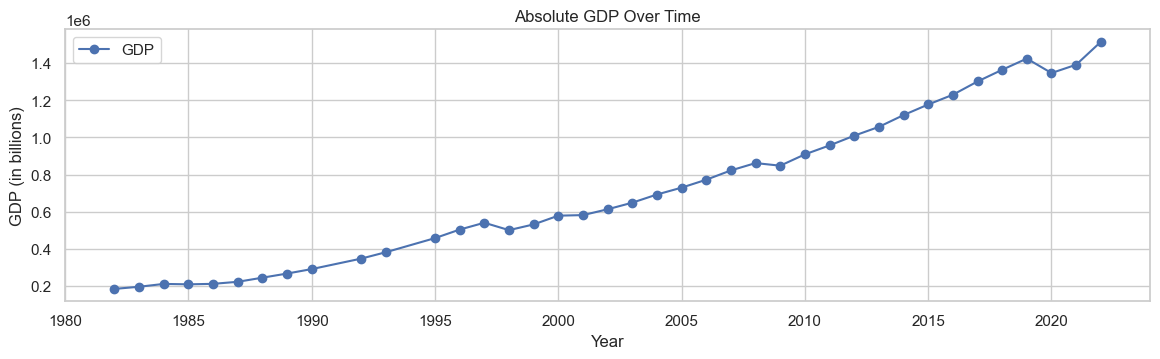

In [ ]:
# Set the style for the plots
sns.set(style="whitegrid")

# Plotting the GDP over time
plt.figure(figsize=(14, 12))

plt.subplot(3, 1, 1)
plt.plot(df.index, df['abs_gdp'], label='GDP', color='b', marker='o')
plt.xlabel('Year')
plt.ylabel('GDP (in billions)')
plt.title('Absolute GDP Over Time')
plt.legend()
plt.grid(True)

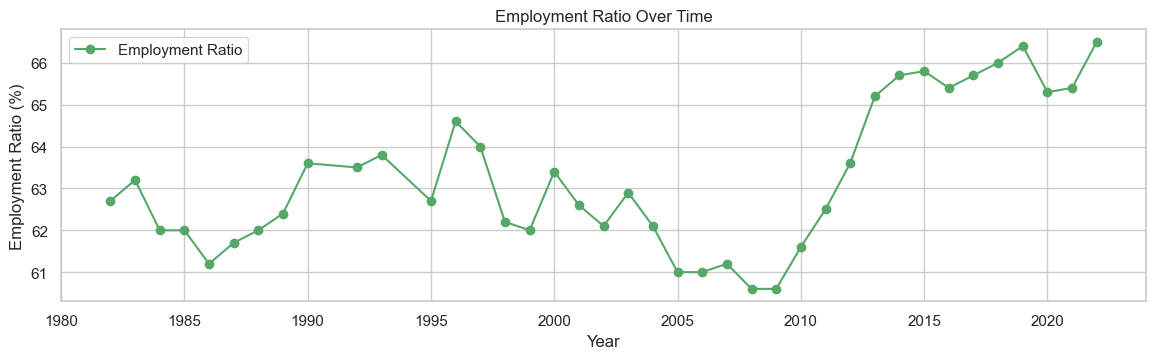

In [ ]:
# Set the style for the plots
sns.set(style="whitegrid")

# Plotting the employment ratio over time
plt.figure(figsize=(14, 12))

plt.subplot(3, 1, 2)
plt.plot(df.index, df['ep_ratio'], label='Employment Ratio', color='g', marker='o')
plt.xlabel('Year')
plt.ylabel('Employment Ratio (%)')
plt.title('Employment Ratio Over Time')
plt.legend()
plt.grid(True)

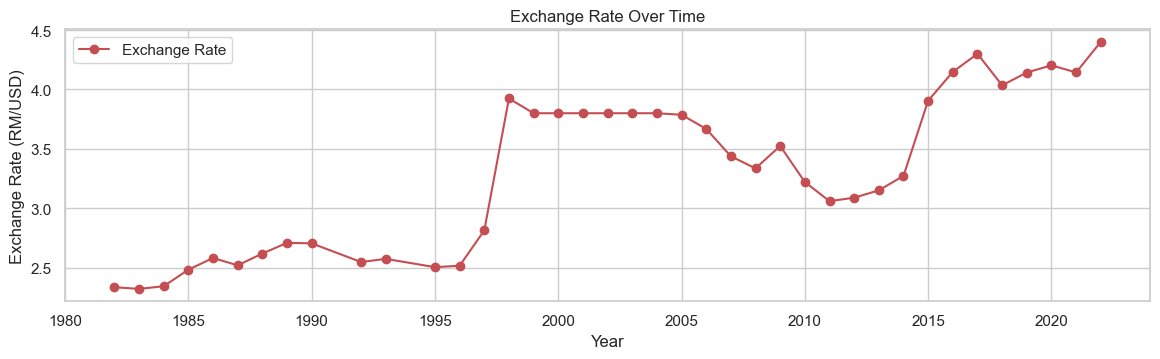

In [ ]:
# Set the style for the plots
sns.set(style="whitegrid")

# Plotting the exchange rate over time
plt.figure(figsize=(14, 12))

plt.subplot(3, 1, 3)
plt.plot(df.index, df['exchange_rate'], label='Exchange Rate', color='r', marker='o')
plt.xlabel('Year')
plt.ylabel('Exchange Rate (RM/USD)')
plt.title('Exchange Rate Over Time')
plt.legend()
plt.grid(True)

### Conduct Correlation Analysis

Correlation analysis is conducted to identify relationships between variables. The correlation matrix for all variables in the dataset is computed and visualized using a heatmap. The heatmap provides a clear view of how each variable is correlated with the others. Specifically, the correlation of various economic indicators with the exchange rate is focused on. This analysis reveals the strength and direction of relationships, which is crucial for feature selection and understanding the underlying economic factors influencing the exchange rate.

In [ ]:
# Correlation matrix
corr_matrix = df.corr()

# Specific correlation between exchange rate and other variables
exchange_rate_corr = corr_matrix['exchange_rate'].sort_values(ascending=False)
print(exchange_rate_corr)


exchange_rate            1.000000
abs_gni_capita           0.811026
abs_gdp_capita           0.803950
abs_gni                  0.801312
lf                       0.799601
lf_outside               0.798492
lf_employed              0.798372
abs_gdp                  0.795757
lf_unemployed            0.592598
ep_ratio                 0.380881
p_rate                   0.230090
growth_yoy_gni_capita   -0.142728
growth_yoy_gdp_capita   -0.204320
growth_yoy_gni          -0.305865
growth_yoy_gdp          -0.352159
u_rate                  -0.364507
blr_value               -0.645063
fdr_1mo_value           -0.674107
inv_fdr_1mo_value       -0.674107
inv_fdr_3mo_value       -0.692763
fdr_3mo_value           -0.692763
fdr_6mo_value           -0.714142
inv_fdr_6mo_value       -0.714142
inv_fdr_9mo_value       -0.723271
fdr_9mo_value           -0.723271
fdr_12mo_value          -0.724573
inv_fdr_12mo_value      -0.724573
alr_value               -0.745427
inv_alr_value           -0.745427
sr_value      

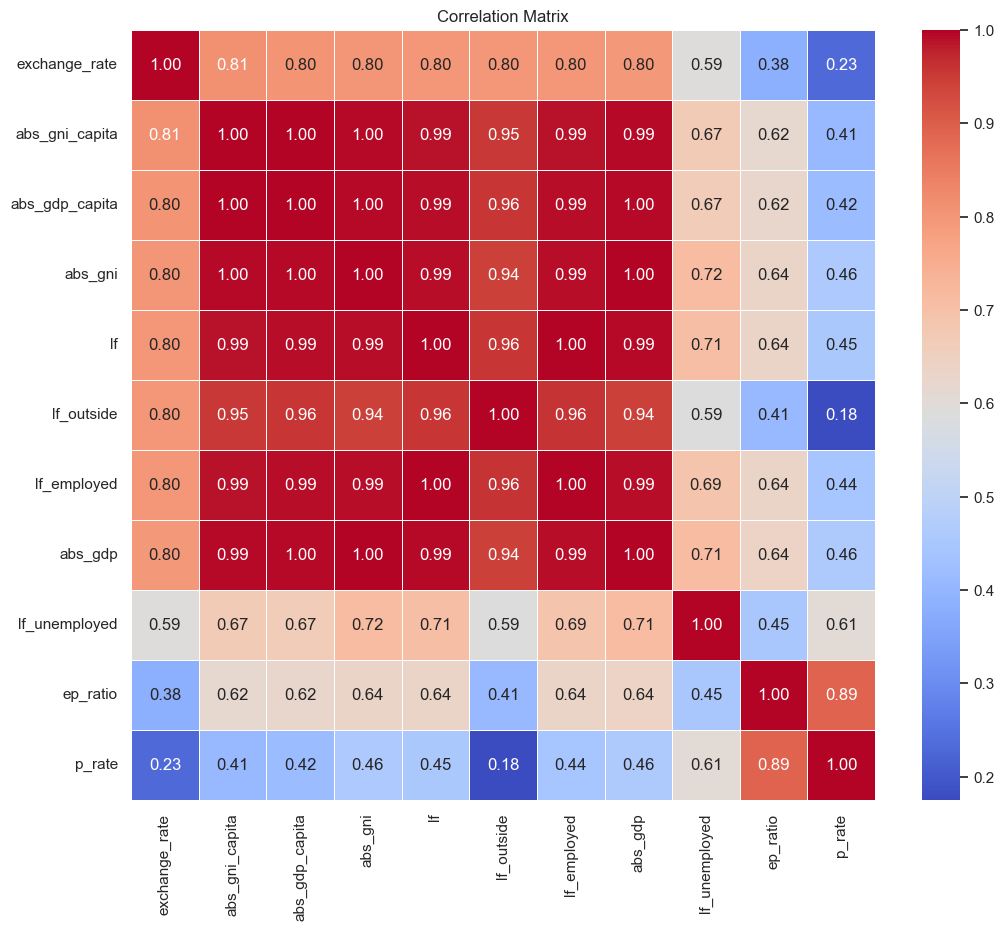

In [ ]:
# Heatmap of the correlation matrix of positive correlation coefficeint only
top_features = exchange_rate_corr.index[0:11] # get top 10
df_top_features = df[top_features]
top_corr_matrix = df_top_features.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

### Create Additional Features

Additional features are created to enhance the predictive power of the model. Moving averages are calculated to smooth out short-term fluctuations and highlight longer-term trends in GDP, employment ratios and exchange rates. Percentage changes are also computed to capture the rate of change over time for these variables. These new features, providing more nuanced insights, are intended to improve the model's ability to forecast future values of the Malaysian Ringgit. The dataset is then cleaned, with the updated version being saved for further analysis and modeling.

In [ ]:
# Load the dataset
df = pd.read_csv('datasets/dataset.csv')

# Calculate moving averages for GDP, exchange rate, and employment rate
df['abs_gdp_ma'] = df['abs_gdp'].rolling(window=2).mean()
df['exchange_rate_ma'] = df['exchange_rate'].rolling(window=2).mean()
df['ep_ratio_ma'] = df['ep_ratio'].rolling(window=2).mean()

# Calculate percentage changes for GDP, exchange rate, and employment rate
df['gdp_pct_change'] = df['abs_gdp'].pct_change()
df['exchange_rate_pct_change'] = df['exchange_rate'].pct_change()
df['ep_ratio_pct_change'] = df['ep_ratio'].pct_change()

# Fill NaN values in percentage changes with 0
df['gdp_pct_change'].fillna(0)
df['exchange_rate_pct_change'].fillna(0)
df['ep_ratio_pct_change'].fillna(0)

# Fill NaN values in moving averages with the original values as a fallback
df['abs_gdp_ma'] = df['abs_gdp_ma'].fillna(df['abs_gdp'])
df['exchange_rate_ma'].fillna(df['exchange_rate'], inplace=True)
df['ep_ratio_ma'].fillna(df['ep_ratio'], inplace=True)

# Reset index to include 'year' as a column
df.reset_index(inplace=True)

# Reorder columns to place 'year' at the beginning
columns_order = [
    'date', 'exchange_rate', 'lf', 'lf_employed', 'lf_unemployed', 'lf_outside', 'p_rate',
    'ep_ratio', 'u_rate', 'abs_gdp', 'abs_gni', 'abs_gdp_capita', 'abs_gni_capita',
    'growth_yoy_gdp', 'growth_yoy_gni', 'growth_yoy_gdp_capita', 'growth_yoy_gni_capita',
    'fdr_1mo_value', 'fdr_3mo_value', 'fdr_6mo_value', 'fdr_9mo_value', 'fdr_12mo_value',
    'sr_value', 'alr_value', 'blr_value', 'inv_fdr_1mo_value', 'inv_fdr_3mo_value',
    'inv_fdr_6mo_value', 'inv_fdr_9mo_value', 'inv_fdr_12mo_value', 'inv_alr_value',
    'abs_gdp_ma', 'exchange_rate_ma', 'ep_ratio_ma',
    'gdp_pct_change', 'exchange_rate_pct_change', 'ep_ratio_pct_change'
]
df = df[columns_order]

# Display the dataframe with new features in the specified order
df.head()

# Save the updated dataset
df.to_csv('datasets/updated_dataset.csv', index=False)


### Additional Visualization

Additional visualizations are created to gain further insights into the newly added features. Moving averages and percentage changes for GDP, employment ratios and exchange rates are plotted to examine their behavior and relevance. By visualizing these features, underlying patterns and trends are identified, aiding in the understanding of their potential impact on the model. These visualizations are intended to ensure that the new features capture significant information, thereby enhancing the predictive capabilities of the model.

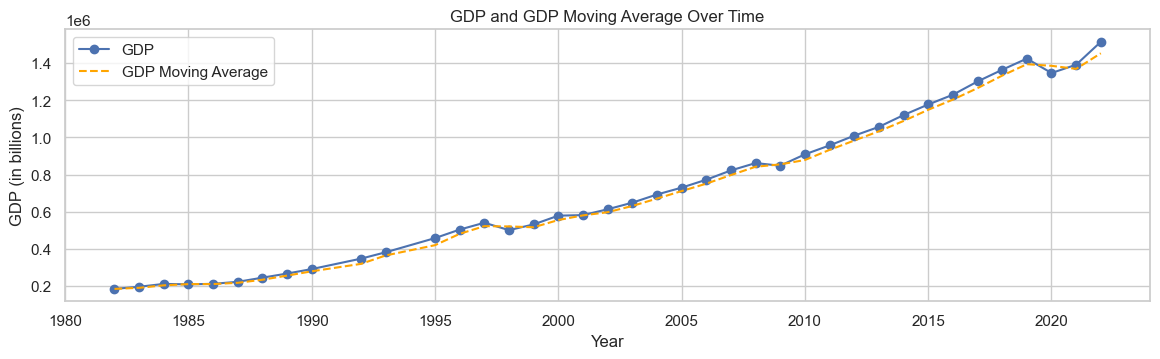

In [ ]:
# Plotting the moving averages for GDP
plt.figure(figsize=(14, 12))

plt.subplot(3, 1, 1)
plt.plot(df['date'], df['abs_gdp'], label='GDP', color='b', marker='o')
plt.plot(df['date'], df['abs_gdp_ma'], label='GDP Moving Average', color='orange', linestyle='--')
plt.xlabel('Year')
plt.ylabel('GDP (in billions)')
plt.title('GDP and GDP Moving Average Over Time')
plt.legend()
plt.grid(True)

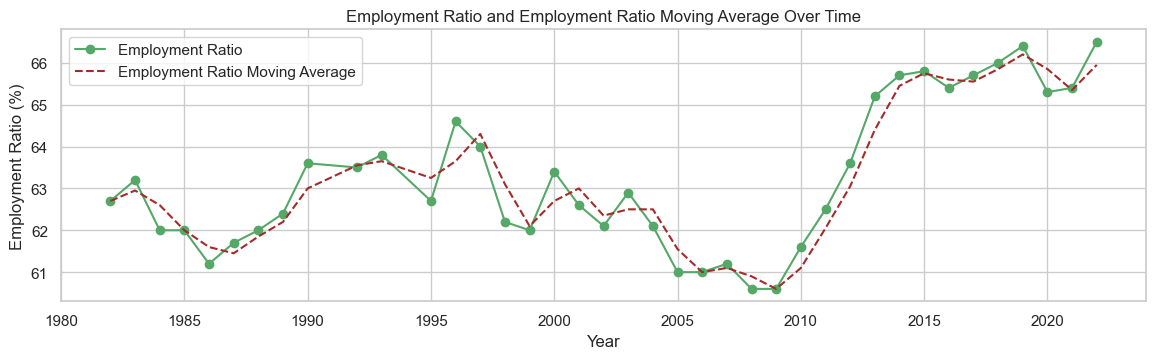

In [ ]:
# Plotting the moving averages for employment ratio
plt.figure(figsize=(14, 12))

plt.subplot(3, 1, 3)
plt.plot(df['date'], df['ep_ratio'], label='Employment Ratio', color='g', marker='o')
plt.plot(df['date'], df['ep_ratio_ma'], label='Employment Ratio Moving Average', color='brown', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Employment Ratio (%)')
plt.title('Employment Ratio and Employment Ratio Moving Average Over Time')
plt.legend()
plt.grid(True)

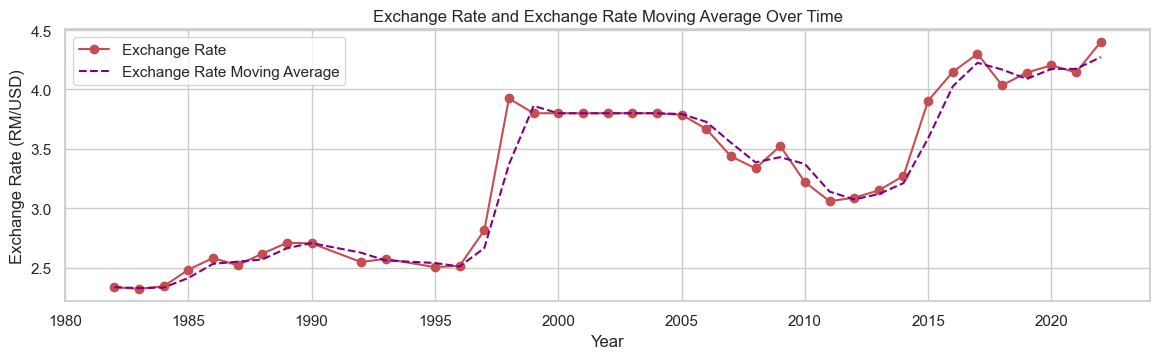

In [ ]:
# Plotting the moving averages for exchange rate
plt.figure(figsize=(14, 12))

plt.subplot(3, 1, 2)
plt.plot(df['date'], df['exchange_rate'], label='Exchange Rate', color='r', marker='o')
plt.plot(df['date'], df['exchange_rate_ma'], label='Exchange Rate Moving Average', color='purple', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Exchange Rate (RM/USD)')
plt.title('Exchange Rate and Exchange Rate Moving Average Over Time')
plt.legend()
plt.grid(True)

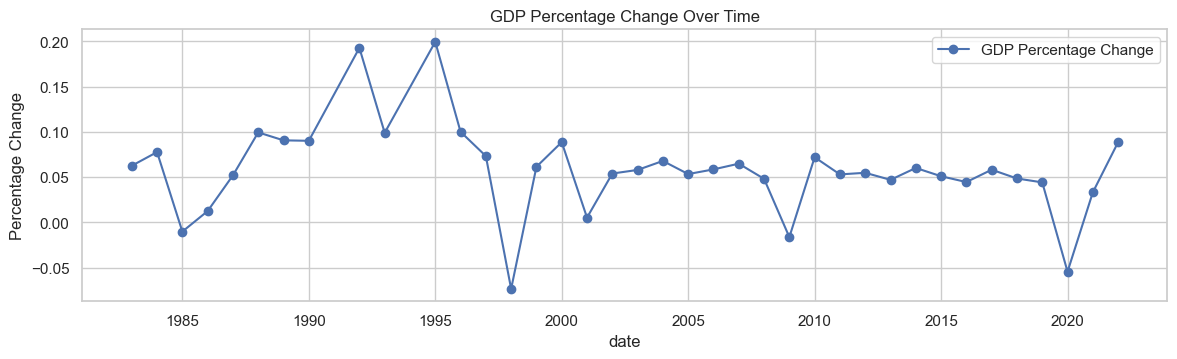

In [ ]:
# Plotting the percentage changes for GDP
plt.figure(figsize=(14, 12))

plt.subplot(3, 1, 1)
plt.plot(df['date'], df['gdp_pct_change'], label='GDP Percentage Change', color='b', marker='o')
plt.xlabel('date')
plt.ylabel('Percentage Change')
plt.title('GDP Percentage Change Over Time')
plt.legend()
plt.grid(True)

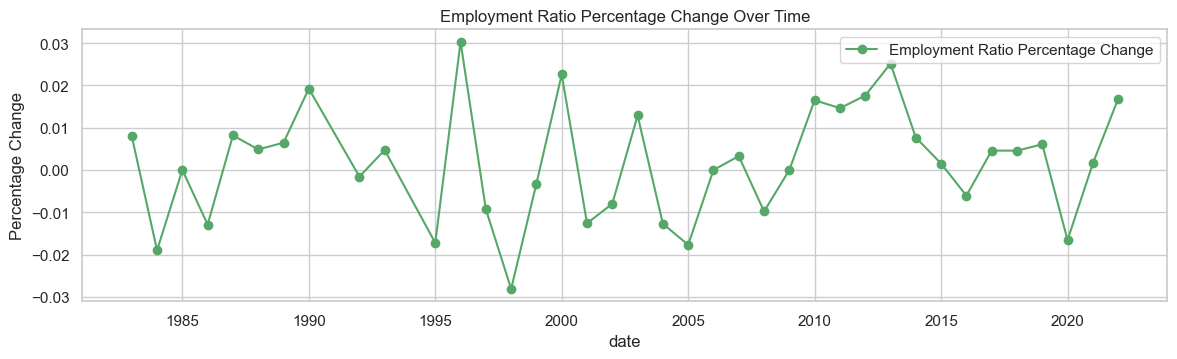

In [ ]:
# Plotting the percentage changes for employment ratio
plt.figure(figsize=(14, 12))

plt.subplot(3, 1, 3)
plt.plot(df['date'], df['ep_ratio_pct_change'], label='Employment Ratio Percentage Change', color='g', marker='o')
plt.xlabel('date')
plt.ylabel('Percentage Change')
plt.title('Employment Ratio Percentage Change Over Time')
plt.legend()
plt.grid(True)

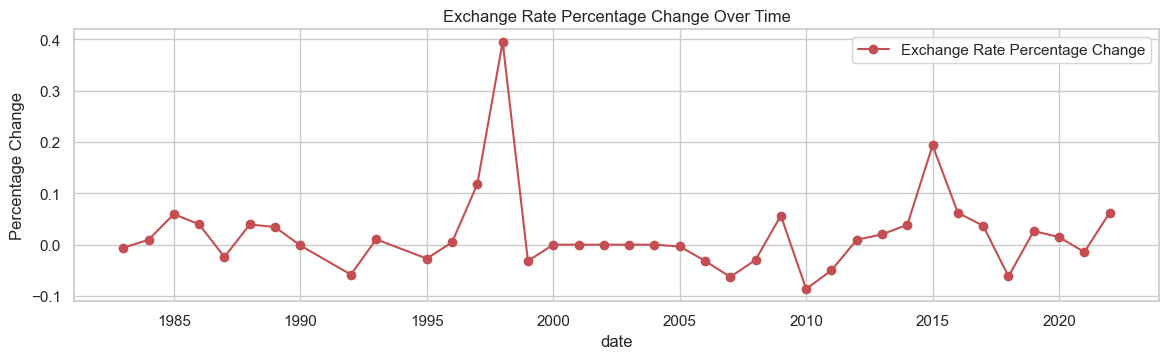

In [ ]:
# Plotting the percentage changes for exchange rate
plt.figure(figsize=(14, 12))

plt.subplot(3, 1, 2)
plt.plot(df['date'], df['exchange_rate_pct_change'], label='Exchange Rate Percentage Change', color='r', marker='o')
plt.xlabel('date')
plt.ylabel('Percentage Change')
plt.title('Exchange Rate Percentage Change Over Time')
plt.legend()
plt.grid(True)

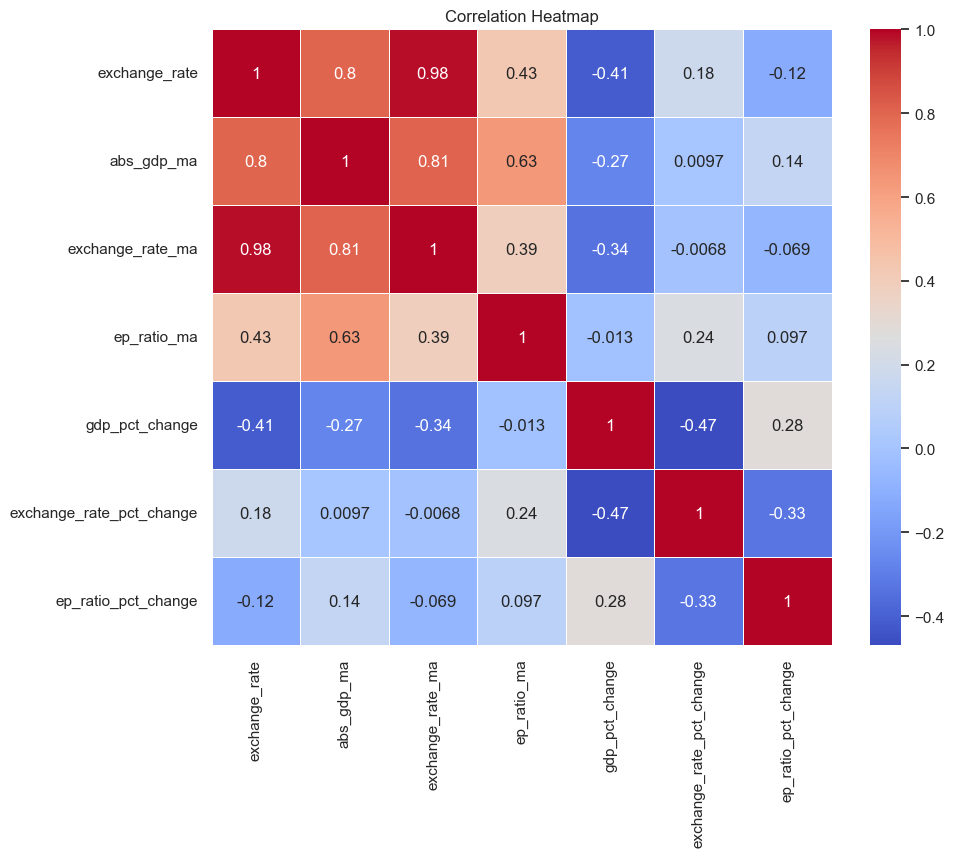

In [ ]:
# checking correlation with the additional features
correlation_columns = ['abs_gdp_ma', 'exchange_rate_ma', 'ep_ratio_ma', 'gdp_pct_change', 'exchange_rate_pct_change', 'ep_ratio_pct_change']
correlations = df[['exchange_rate'] + correlation_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Machine Learning Techniques

Before we started to do the model selection and training, we have to perform the Principle Component Analysis (PCA) and split the dataset into training set and testing set. The PCA will be performed to reduce the dimension of the dataset and maintain the variance as much as possible before we start to split the dataset. We are going to split the dataset with 8:2 ratio so that we will not miss the temporal order of the dataset. Therefore, first 80% of the dataset will be our traning set and the rest of the 20% will be our testing set.

## Linear Regression

### Identify the features and target

First, we need too identify x and y, which are the features we have and the target we need. Since our project is doing exchange rate prediction, our target will be the exchange rate while the others will be the features.

In [ ]:
df = pd.read_csv('datasets/updated_dataset.csv')

In [ ]:
# Correlation matrix
corr = df.corr()

# Specific correlation between exchange rate and other variables
exchange_rate_corr = corr['exchange_rate'].sort_values(ascending=False)
print(exchange_rate_corr)


exchange_rate               1.000000
exchange_rate_ma            0.983584
date                        0.826298
abs_gni_capita              0.811026
abs_gdp_capita              0.803950
abs_gni                     0.801312
abs_gdp_ma                  0.801060
lf                          0.799601
lf_outside                  0.798492
lf_employed                 0.798372
abs_gdp                     0.795757
lf_unemployed               0.592598
ep_ratio_ma                 0.431052
ep_ratio                    0.380881
p_rate                      0.230090
exchange_rate_pct_change    0.177618
ep_ratio_pct_change        -0.124437
growth_yoy_gni_capita      -0.142728
growth_yoy_gdp_capita      -0.204320
growth_yoy_gni             -0.305865
growth_yoy_gdp             -0.352159
u_rate                     -0.364507
gdp_pct_change             -0.414245
blr_value                  -0.645063
fdr_1mo_value              -0.674107
inv_fdr_1mo_value          -0.674107
inv_fdr_3mo_value          -0.692763
f

In [ ]:
# extract features with positive correlation coefficient
high_corr_features = corr.loc[corr['exchange_rate'] > 0.4, 'exchange_rate']
print(high_corr_features)

high_corr_features = high_corr_features.index.tolist()
high_corr_features.remove('exchange_rate')



date                0.826298
exchange_rate       1.000000
lf                  0.799601
lf_employed         0.798372
lf_unemployed       0.592598
lf_outside          0.798492
abs_gdp             0.795757
abs_gni             0.801312
abs_gdp_capita      0.803950
abs_gni_capita      0.811026
abs_gdp_ma          0.801060
exchange_rate_ma    0.983584
ep_ratio_ma         0.431052
Name: exchange_rate, dtype: float64


In [ ]:
# Identify the target and features
x = df[high_corr_features]
y = df["exchange_rate"].values.reshape((-1,1))

### Performing Priniple Component Analysis (PCA)

Next, we will have to perform the PCA to analyze our dataset. This action is to reduce the dimension while maintaning the variance of the dataset. In this case, we will standardlize the features ofo our dataset to have 0 mean and unit variance, then we apply PCA to the standardlized data.

In [ ]:
# Standardlize the data
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Performing PCA
pca = PCA(0.80) # Maintain 80% of the variance while performing PCA
x_pca = pca.fit_transform(x_scaled)

### Splitting the dataset

Now we will split the transformed dataset into traning and testing sets with the ratio of 8:2.

In [ ]:
# Splitting the data with 8:2 ratio
splitting = int(len(df) * 0.8) # Index has to be int to work
x_train = x_pca[:splitting]
x_test = x_pca[splitting:]
y_train = y[:splitting]
y_test = y[splitting:]

# Print the x_train shape, x_test shape, y_train shape and y_test shape
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(31, 1)
(8, 1)
(31, 1)
(8, 1)


### Model traning

Before we start the model training, we have to decide which model that we are going to use based on their performance and the ability of its prediction. In this case, we chose linear regression as our model. This is because linear regression is better for predicting a continuous variable and when there is a linear relationship between the variables. Our aim is to predict the exchange rate of a currency, and it is a continuous value. Therefore, linear regression is suitable for our dataset. We will put the x_train and y_train as the training data to train the model, and then put the x_test as the testing set for the model to predict the output.

In [ ]:
# Train the linear regression model
model = LinearRegression()
model.fit(x_train, y_train)

# Fit the testing set for the model to predict
result = model.predict(x_test)

# Print the result
print(f"Predicted value: \n{result}")

Predicted value: 
[[3.89034783]
 [3.97723282]
 [4.04923016]
 [4.1031465 ]
 [4.16189308]
 [4.18759753]
 [4.21182699]
 [4.28464308]]


In [ ]:
# Actual values for comparison to above
print(f"Predicted value: \n{y_test}")

Predicted value: 
[[3.90550026]
 [4.14830066]
 [4.30044088]
 [4.03513014]
 [4.14246974]
 [4.20348195]
 [4.1432976 ]
 [4.40107634]]


##### Get The Coefficient(Slope) and Intercept for Future Prediction

In [ ]:
# Get the coefficient from the model
coefficient = model.coef_

# Print the coefficient
print(f"Coefficient = {coefficient}")

# Transform PCA coefficients back to original for each feature
ori_coefficient = pca.inverse_transform(coefficient)

# Rearrange the original coefficcient into a list
ori_slope = list()
for i in ori_coefficient:
    for j in i :
        ori_slope.append(j)

#print the original coefficient
for feature, slope in zip(x, ori_slope):
    print(f"The Coefficient for {feature} = {slope}")

Coefficient = [[0.16470005]]
The Coefficient for date = 0.05041318441298183
The Coefficient for lf = 0.05074121975774203
The Coefficient for lf_employed = 0.05068004762563002
The Coefficient for lf_unemployed = 0.03716494491896895
The Coefficient for lf_outside = 0.04835438205930935
The Coefficient for abs_gdp = 0.05077627587244581
The Coefficient for abs_gni = 0.05078484808659025
The Coefficient for abs_gdp_capita = 0.05062912414995411
The Coefficient for abs_gni_capita = 0.05061462153433999
The Coefficient for abs_gdp_ma = 0.050796940338898915
The Coefficient for exchange_rate_ma = 0.04276946579664396
The Coefficient for ep_ratio_ma = 0.032094606290690796


### Model Evaluation

For model evaluation, we did the Mean Squared Error (MSE), Root Mean Square Error (RMSE), R-Squared Score, Residual Analysis and Cross Validation. <br>
*MSE* - to measure the average squared difference between the predicted values (which is our result) and actual values (y_test).<br>
*RMSE* - to measure the average magnitude of the residuals.<br>
*R-Squared Score* - to measure the prooportion of the model.<br>
*Residual Analysis* - to measure the difference between the result and y_test.<br>
*Cross Validation* - to help in accessing the model's ability to generalize the new data.

MSE: 0.01451367710058476
RMSE: 0.12047272347126864
R-squared: 0.025703473058582338
Cross-validated R-squared: -8.681775053066708 (±10.876262155121038)


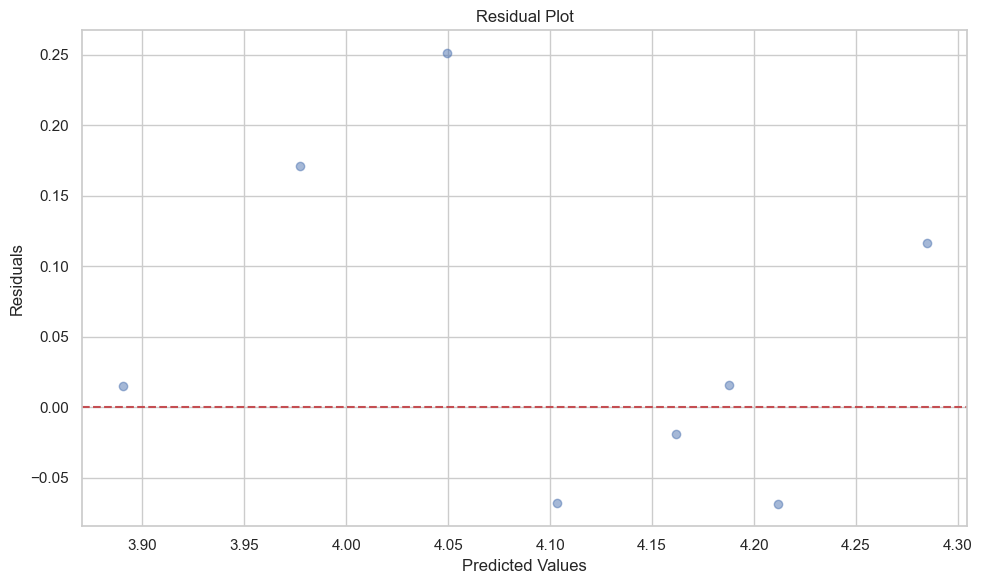

In [ ]:
# Mean Squared Error & Root Mean Square Error
mse = mean_squared_error(result, y_test)
rmse = np.sqrt(mse)

# R-Squared Sore
r2 = r2_score(result, y_test)

# Cross validation
cv_scores = cross_val_score(model, x, y, cv=5, scoring='r2')

# Residual Analysis
residual = y_test - result

# Visualizing the analysis
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")
print(f"Cross-validated R-squared: {np.mean(cv_scores)} (±{np.std(cv_scores)})")

# Plot the residual
plt.figure(figsize=(10, 6))
plt.scatter(result, residual, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

The model's evaluation metrics suggest that while the absolute prediction errors (MSE and RMSE) are small, the model is not effective at explaining the variability in the exchange rate data (low R²) and does not generalize well (negative cross-validated R²). This indicates that the linear regression model might not be suitable for this problem.

This can be attribute to the complexity of predicting currency exchange; it is not as simple as a straight line.

## Random Forest Regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [ ]:
# x = df[['lf', 'lf_employed', 'lf_unemployed', 'lf_outside', 'p_rate',
#     'ep_ratio', 'u_rate', 'abs_gdp', 'abs_gni', 'abs_gdp_capita', 'abs_gni_capita',
#     'growth_yoy_gdp', 'growth_yoy_gni', 'growth_yoy_gdp_capita', 'growth_yoy_gni_capita',
#     'fdr_1mo_value', 'fdr_3mo_value', 'fdr_6mo_value', 'fdr_9mo_value', 'fdr_12mo_value',
#     'sr_value', 'alr_value', 'blr_value', 'inv_fdr_1mo_value', 'inv_fdr_3mo_value',
#     'inv_fdr_6mo_value', 'inv_fdr_9mo_value', 'inv_fdr_12mo_value', 'inv_alr_value',
#     'abs_gdp_ma', 'exchange_rate_ma', 'ep_ratio_ma',
#     'gdp_pct_change', 'exchange_rate_pct_change', 'ep_ratio_pct_change']]
x = df[high_corr_features]
y = df['exchange_rate']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42) # 60% train, 40% test

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)


RandomForestRegressor(random_state=42)

In [ ]:
y_pred = rf.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse}")
print(f"R-squared: {r2}")

MSE: 0.017229140292786042
R-squared: 0.9509878970667599


In [ ]:
# comparison of Actual vs Predicted
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(comparison.head(10))

      Actual  Predicted
33  4.300441   4.122748
36  4.203482   4.109395
4   2.581442   2.494970
13  2.813192   2.811939
30  3.272860   3.255173
26  3.221087   3.573057
6   2.618783   2.570429
27  3.060003   3.191155
24  3.335833   3.539948
15  3.800000   3.747268


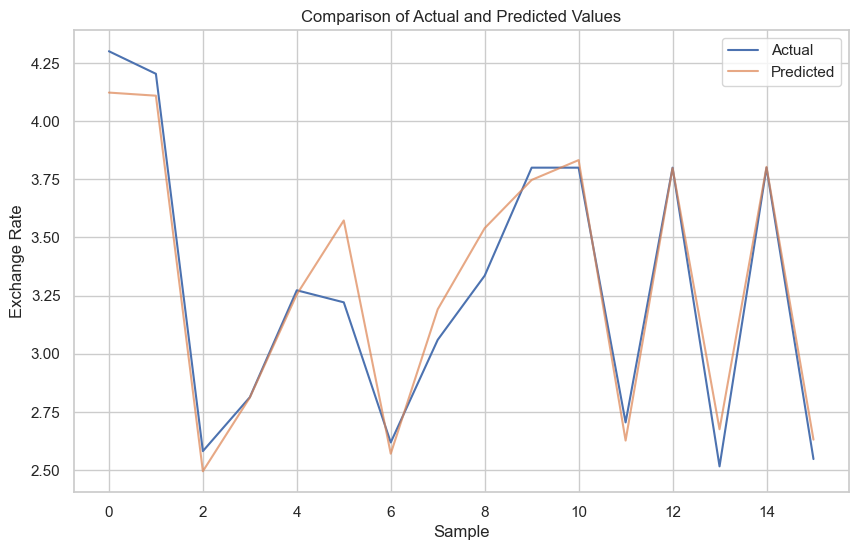

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.legend()
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample')
plt.ylabel('Exchange Rate')
plt.show()

Random Forest Regression model has a good fit as shown in the line graph. The model was able to explain most of the variability in the exchange rate data, capturing the underlying trends and patterns effectively.

## New ML technique: Prophet model (not covered in lecture)

A new model technique is the Prophet model, an open-source forecasting tool developed by Facebook. is designed to handle time series data with strong seasonal patterns and a variety of other features, making it suitable for predicting currency exchange rates.

In [ ]:
# install Facebook's Prophet library
#! pip install prophet

In [4]:
from prophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [6]:
df = pd.read_csv('monthlyRate.csv')

In [7]:
df['date'] = pd.to_datetime(df['date'], format='%d-%b-%y')

df = df.rename(columns={'date': 'ds', 'USD': 'y'})

In [15]:
train_size = int(len(df) * 0.8)  # 80% train, 20% test
train_df = df[:train_size]
test_df = df[train_size:]

In [ ]:
model = Prophet()
model.fit(train_df)

In [32]:
future_dates = test_df[['ds']]
forecast = model.predict(future_dates)

In [33]:
# predicted values vs actual values
predicted_values = forecast['yhat'].values
actual_values = test_df['y'].values

print(predicted_values)
print(actual_values)

[4.73367748 4.73233181 4.73401744 4.7353045  4.73796621 4.73174995
 4.73040428 4.73208991 4.73337697 4.72982241 4.72847674 4.73016237
 4.73144943 4.73411114 4.72789488 4.72654921 4.72823484 4.7295219
 4.73218361 4.72596735 4.72462168 4.72630731 4.72759437 4.72403982
 4.72269415 4.72437977 4.72566684 4.72832855 4.72211228 4.72076661
 4.7237393  4.72640101 4.72018475 4.71883908 4.72052471 4.72181177
 4.72447348 4.71825722 4.71691155 4.71988424 4.72254595 4.71632969
 4.71498401 4.71666964 4.7179567  4.72061841 4.71440215 4.71305648
 4.71474211 4.71602917]
[4.7835 4.783  4.7825 4.7775 4.778  4.78   4.7675 4.7695 4.77   4.7535
 4.7415 4.74   4.7375 4.7465 4.7395 4.739  4.733  4.7195 4.7035 4.6845
 4.6875 4.685  4.6935 4.712  4.7135 4.6985 4.6965 4.7075 4.707  4.707
 4.7    4.696  4.6945 4.6925 4.722  4.721  4.7175 4.7075 4.715  4.714
 4.708  4.7105 4.7095 4.711  4.7025 4.7125 4.7225 4.7195 4.713  4.7215]


In [34]:
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
print(f"Root Mean Squared Error (RMSE): {rmse}")
r2 = r2_score(actual_values, predicted_values)
print(f"R^2 Score: {r2}")

Root Mean Squared Error (RMSE): 0.025238152613356282
R^2 Score: 0.235252823317591


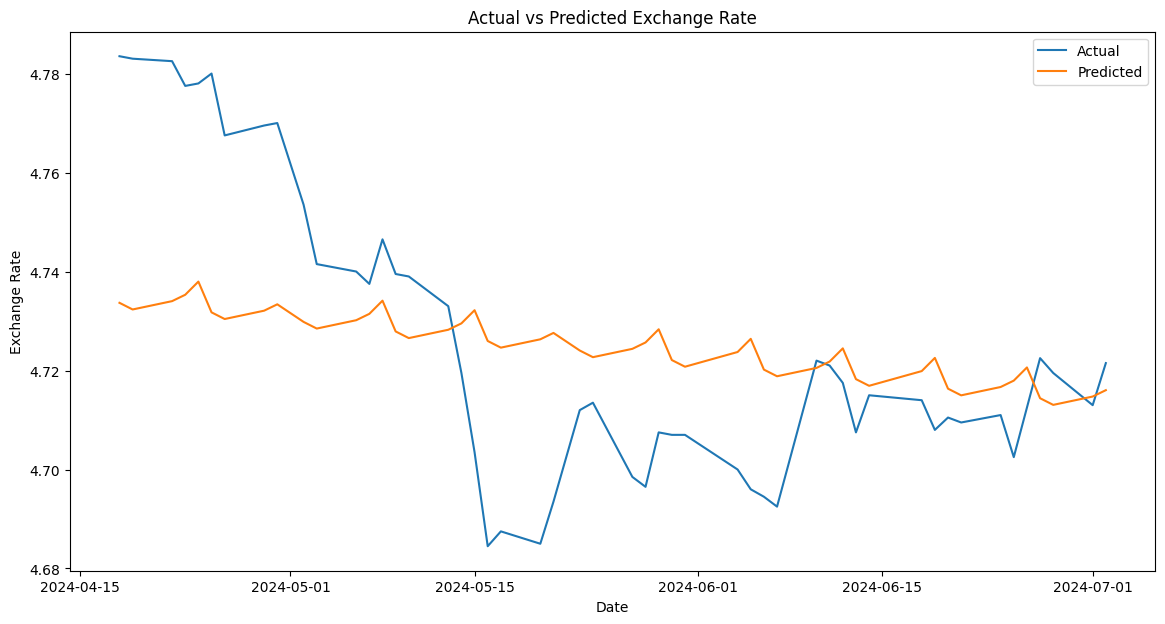

In [25]:
# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(test_df['ds'], actual_values, label='Actual')
plt.plot(test_df['ds'], predicted_values, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('Actual vs Predicted Exchange Rate')
plt.legend()
plt.show()


The predictability of the Prophet model is still lacking. However, we believe including more data of economic indicators by the months can greatly improve this model (unfortunately majority of our datas are collected by the years only).

### Predicting the next 5 months exchange rate

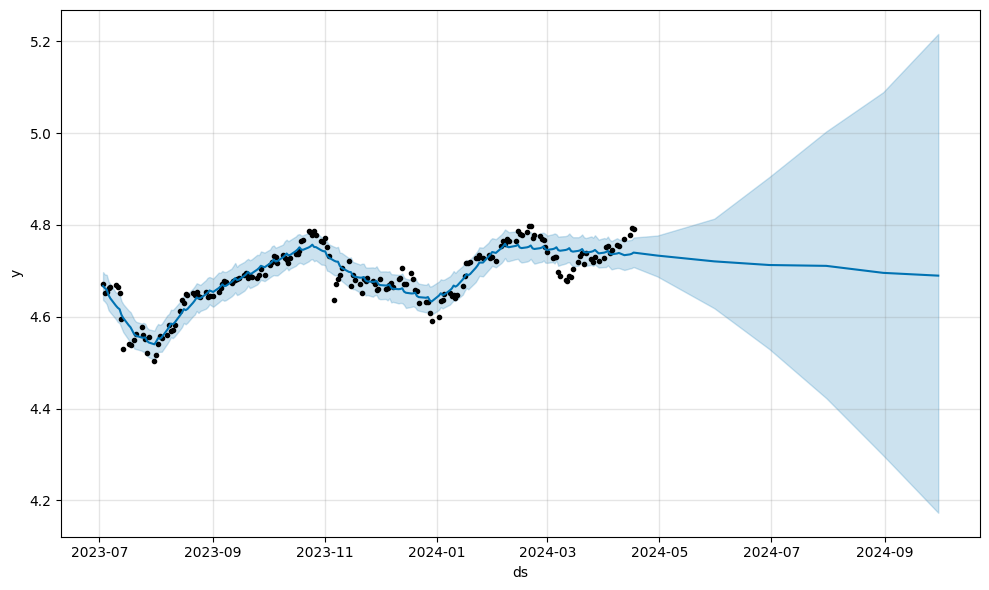

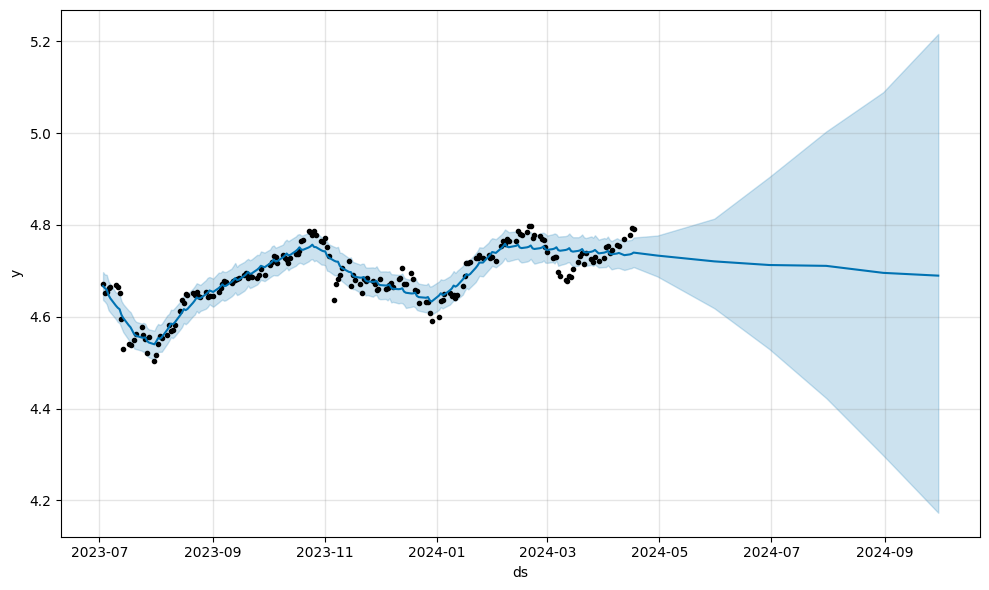

In [39]:
# predicting the next 5 months
future = model.make_future_dataframe(periods=6, freq='M')
forecast = model.predict(future)
model.plot(forecast)

In [38]:
predictions = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
print(predictions.tail())  # Display the last few predictions


            ds      yhat  yhat_lower  yhat_upper
197 2024-05-31  4.720767    4.618063    4.825506
198 2024-06-30  4.712823    4.530698    4.901187
199 2024-07-31  4.710981    4.427194    5.000986
200 2024-08-31  4.695751    4.292374    5.102673
201 2024-09-30  4.689684    4.161307    5.233261


The yhat is the predicted value of the exchange rate for that date. The yhat_lower column represents potential minimum value the exchange rate could be. While the yhat_upper gives an idea of the potential maximum value the exchange rate could be.

# Conclusion

The Random Forest Regression model performed the best in predicting currency exchange rates. The model's accuracy and ability to capture the underlying patterns in our datasets make it an ideal choice for this task, as demonstrated by its low MSE and high R² values..

Random Forest's strength was its ability to capture non-linear relationships between features and the target variable, which explains its superior performance in comparison to linear regression.

While Prophet is a powerful tool for time series forecasting, it works better if additional relevant features are included. Especially if incorporated with datas from financial markets, such as commodity prices (e.g., petroleum, oil, rubber). This integration can better capture underlying patterns and seasonality in the data, leading to more accurate predictions. Currently, most of our economic indicators data are collected annually which poses a challenge given that the Prophet model is known to perform better with monthly data.